In [1]:
import fastai2
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.layers import *
from fastai2.torch_imports import *
from torch.nn.utils import weight_norm, spectral_norm

## Data

In [2]:
path = Path('/home/jupyter/data/coco'); path.ls(), len(get_files(path))

((#82783) [/home/jupyter/data/coco/COCO_train2014_000000153985.jpg,/home/jupyter/data/coco/COCO_train2014_000000399983.jpg,/home/jupyter/data/coco/COCO_train2014_000000323774.jpg,/home/jupyter/data/coco/COCO_train2014_000000011426.jpg,/home/jupyter/data/coco/COCO_train2014_000000545128.jpg,/home/jupyter/data/coco/COCO_train2014_000000470618.jpg,/home/jupyter/data/coco/COCO_train2014_000000106941.jpg,/home/jupyter/data/coco/COCO_train2014_000000024980.jpg,/home/jupyter/data/coco/COCO_train2014_000000500585.jpg,/home/jupyter/data/coco/COCO_train2014_000000284088.jpg...],
 82783)

In [3]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=lambda *a, **kw: get_image_files(*a, **kw),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_y=lambda x: x,
                 )

In [4]:
bs, sz = 28, 256
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[*aug_transforms(), Normalize(*imagenet_stats)])
dbch.c = 3

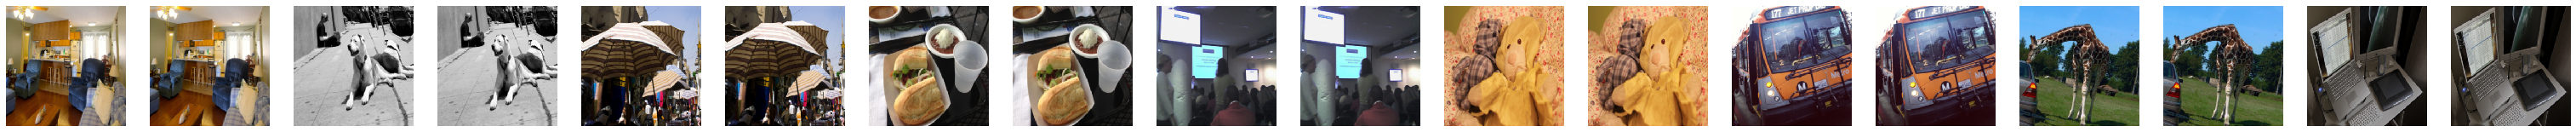

In [5]:
dbch.show_batch(rows=1)

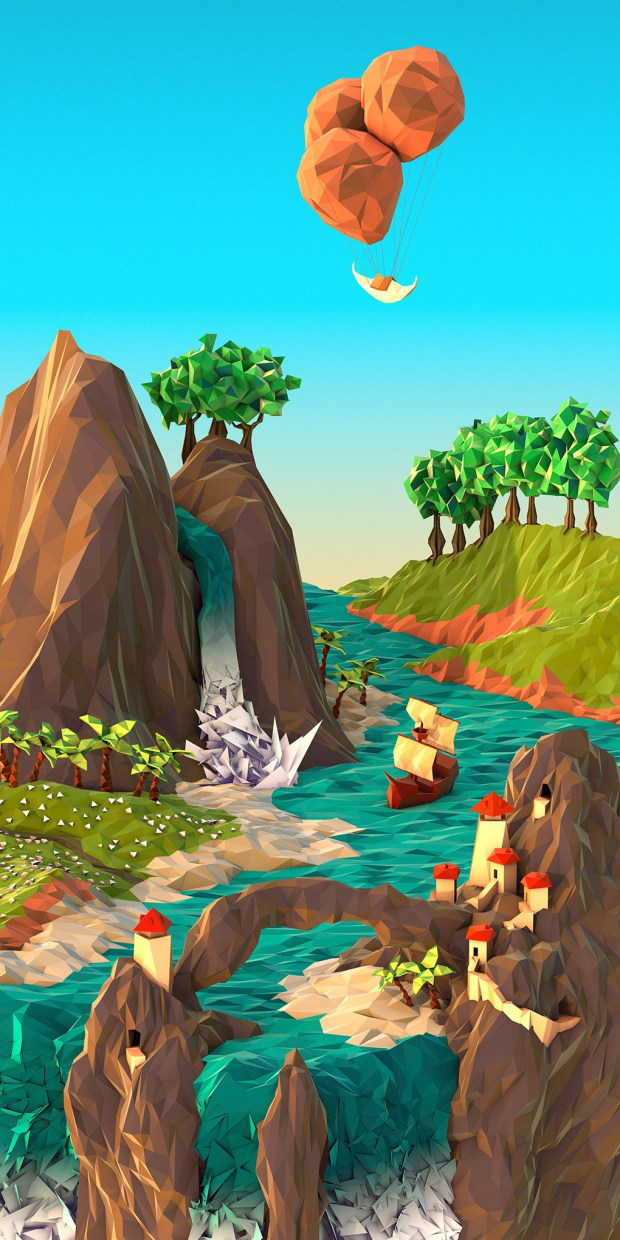

In [6]:
# How can I be sure this is working correctly?
fn = 'styles/landscape_cove.jpg'
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe(fn).cuda());
PILImage.create(fn)

## Loss func

In [7]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [8]:
base_loss = F.l1_loss
class FSTLoss(nn.Module):
    def __init__(self, m_feat, cnt_ls, stl_ls, cnt_lsw, stl_lsw, stl_loss_mult=1e6):
        super().__init__()
        assert len(cnt_ls) == len(cnt_lsw)
        assert len(stl_ls) == len(stl_lsw)
        self.m_feat,self.cnt_ls,self.stl_ls,self.stl_loss_mult=m_feat,cnt_ls,stl_ls,stl_loss_mult
        self.cnt_lsw = tensor(cnt_lsw).float() / sum(cnt_lsw)
        self.stl_lsw = tensor(stl_lsw).float() / sum(stl_lsw)
        self.cnt_hooks = hook_outputs(cnt_ls, detach=False)
        self.stl_hooks = hook_outputs(stl_ls, detach=False)
        self.metric_names = ['style', 'content']
        # TODO: Temporary
        self.reset_metrics()
        
    def reset_metrics(self): self.metrics = dict(style=[], content=[])
        
    def register_style(self, timg):  _,self.stl_fs = self.get_fs(timg, True)

    def get_fs(self, x, clone=False):
        self.m_feat(x)
        cnt_fs = [(o.clone() if clone else o) for o in self.cnt_hooks.stored]
        stl_fs = [(o.clone() if clone else o) for o in self.stl_hooks.stored]
        return cnt_fs, stl_fs
    
    def forward(self, pred, targ, **kwargs):
        pred_cnt_fs, pred_stl_fs = self.get_fs(pred, True)
        targ_cnt_fs, targ_stl_fs = self.get_fs(targ)
        stl_loss = self.stl_loss_mult*self._stl_loss(pred_stl_fs)
        cnt_loss = self._cnt_loss(pred,targ,pred_cnt_fs,targ_cnt_fs)
        # self.metrics = dict(zip(self.metric_names, [stl_loss, cnt_loss]))
        self.metrics['style'].append(stl_loss); self.metrics['content'].append(cnt_loss)
        return stl_loss + cnt_loss
        
    def _stl_loss(self, pred_fs):
        stl_loss = [base_loss(gram(pred_f),gram(style_f))*w
                    for pred_f,style_f,w in zip(pred_fs,self.stl_fs,self.stl_lsw)]
        return sum(stl_loss)
    
    def _cnt_loss(self, pred, targ, pred_fs, targ_fs):
        cnt_loss =  [base_loss(pred,targ)]
        cnt_loss += [base_loss(pred_f,targ_f)*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        cnt_loss += [base_loss(gram(pred_f),gram(targ_f))*w for pred_f,targ_f,w
                     in zip(pred_fs,targ_fs,self.cnt_lsw)]
        return sum(cnt_loss)

In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()
for p in vgg_m.parameters(): p.requires_grad = False
vgg_m.eval(); requires_grad(vgg_m)

False

In [10]:
blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
bnecks = [vgg_m[i] for i in blocks]

In [11]:
fst_loss = FSTLoss(vgg_m, cnt_ls =bnecks[3:4], stl_ls= bnecks[1:],
                          cnt_lsw=[1]      , stl_lsw=[1, 1, 1, 1], stl_loss_mult=1e5)
fst_loss.register_style(style_timg)

In [12]:
opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, **kwargs))

## Transformer net

In [13]:
#Cell
def _conv_func(ndim=2, transpose=False):
    "Return the proper conv `ndim` function, potentially `transposed`."
    assert 1 <= ndim <=3
    return getattr(nn, f'Conv{"Transpose" if transpose else ""}{ndim}d')

In [14]:
#export
def InstanceNorm(nf, norm_type=NormType.Instance, ndim=2, affine=True, **kwargs):
    "Instance layer with `nf` features and `ndim` initialized depending on `norm_type`."
    assert 1 <= ndim <= 3
    bn = getattr(nn, f"InstanceNorm{ndim}d")(nf, affine=affine, **kwargs)
    bn.bias.data.fill_(1e-3)
    bn.weight.data.fill_(0. if norm_type==NormType.InstanceZero else 1.)
    return bn

In [15]:
# export
class ConvLayer(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init=nn.init.kaiming_normal_, xtra=None, **kwargs):
        if padding is None: padding = ((ks-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpose)
        conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs), init)
        # Maybe refactor this pieces, all should go to get_norm or something
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act_cls is not None: act_bn.append(act_cls())
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)
fastai2.layers.ConvLayer = ConvLayer

In [16]:
class ResBlock(nn.Module):
    "Resnet block from `ni` to `nh` with `stride`"
    @delegates(ConvLayer.__init__)
    def __init__(self, expansion, ni, nh, stride=1, sa=False, sym=False,
                 norm_type=NormType.Batch, act_cls=defaults.activation, ndim=2, **kwargs):
        super().__init__()
        norm2 = NormType.BatchZero if norm_type==NormType.Batch else norm_type
        norm2 = NormType.InstanceZero if norm_type==NormType.InstanceZero else norm_type
        nf,ni = nh*expansion,ni*expansion
        layers  = [ConvLayer(ni, nh, 3, stride=stride, norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs),
                   ConvLayer(nh, nf, 3, norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        ] if expansion == 1 else [
                   ConvLayer(ni, nh, 1, norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs),
                   ConvLayer(nh, nh, 3, stride=stride, norm_type=norm_type, act_cls=act_cls, ndim=ndim, **kwargs),
                   ConvLayer(nh, nf, 1, norm_type=norm2, act_cls=None, ndim=ndim, **kwargs)
        ]
        self.convs = nn.Sequential(*layers)
        self.sa = SimpleSelfAttention(nf,ks=1,sym=sym) if sa else noop
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None, ndim=ndim, **kwargs)
        self.pool = noop if stride==1 else AvgPool(2, ndim=ndim, ceil_mode=True)
        self.act = defaults.activation(inplace=True) if act_cls is defaults.activation else act_cls()

    def forward(self, x): return self.act(self.sa(self.convs(x)) + self.idconv(self.pool(x)))

In [17]:
#export
class XResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000, sa=False, sym=False, act_cls=defaults.activation, norm_type=NormType.Batch):
        stem = []
        sizes = [c_in,16,32,64] if c_in<3 else [c_in,32,32,64]
        for i in range(3):
            stem.append(ConvLayer(sizes[i], sizes[i+1], stride=2 if i==0 else 1, norm_type=norm_type, act_cls=act_cls))

        block_szs = [64//expansion,64,128,256,512] +[256]*(len(layers)-4)
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2,
                                  sa = sa if i==len(layers)-4 else False, sym=sym, act_cls=act_cls, norm_type=norm_type)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride, sa, sym, act_cls, norm_type):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1,
                      sa if i==blocks-1 else False, sym=sym, act_cls=act_cls, norm_type=norm_type)
              for i in range(blocks)])
fastai2.vision.models.xresnet.XResNet = XResNet

In [18]:
Conv = partial(ConvLayer, norm_type=NormType.Instance)
Res = partial(ResBlock, 1, norm_type=NormType.Instance)
tn = nn.Sequential(
    Conv(3, 32, stride=2),
    Conv(32, 32, stride=1),
    Conv(32, 64, stride=1),
    Conv(64, 64, stride=2),
    Conv(64, 128, stride=2),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
    Res(128, 128),
)
utn = DynamicUnet(tn, 3, (256, 256), norm_type=NormType.Instance, blur=True, self_attention=True, y_range=(-3, 3))

In [19]:
learn = Learner(dbch, utn, loss_func=fst_loss, opt_func=opt_func)

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # Annoying pytorch broadcast warning: (torch.Size([1, 512, 512])) that is different to the input size (torch.Size([32, 512, 512]))

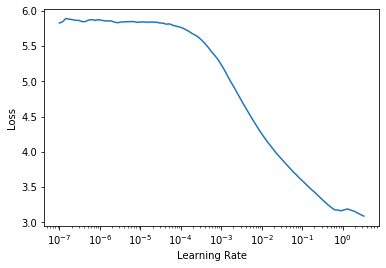

In [21]:
learn.lr_find()

In [22]:
learn.fit_flat_cos(1, 4e-2)

In [54]:
learn.path

PosixPath('.')

In [55]:
learn.save('utn-cove-256_1')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3d7ed52440>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


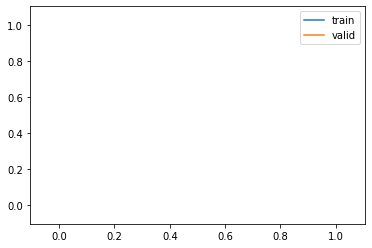

In [53]:
learn.recorder.plot_loss(skip_start=2000)

In [32]:
fst_loss.reset_metrics()

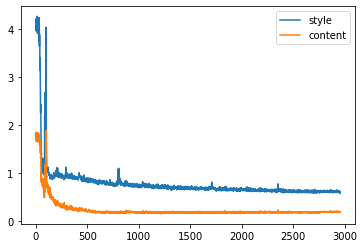

In [25]:
for n, v in fst_loss.metrics.items(): plt.plot(v, label=n)
plt.legend()

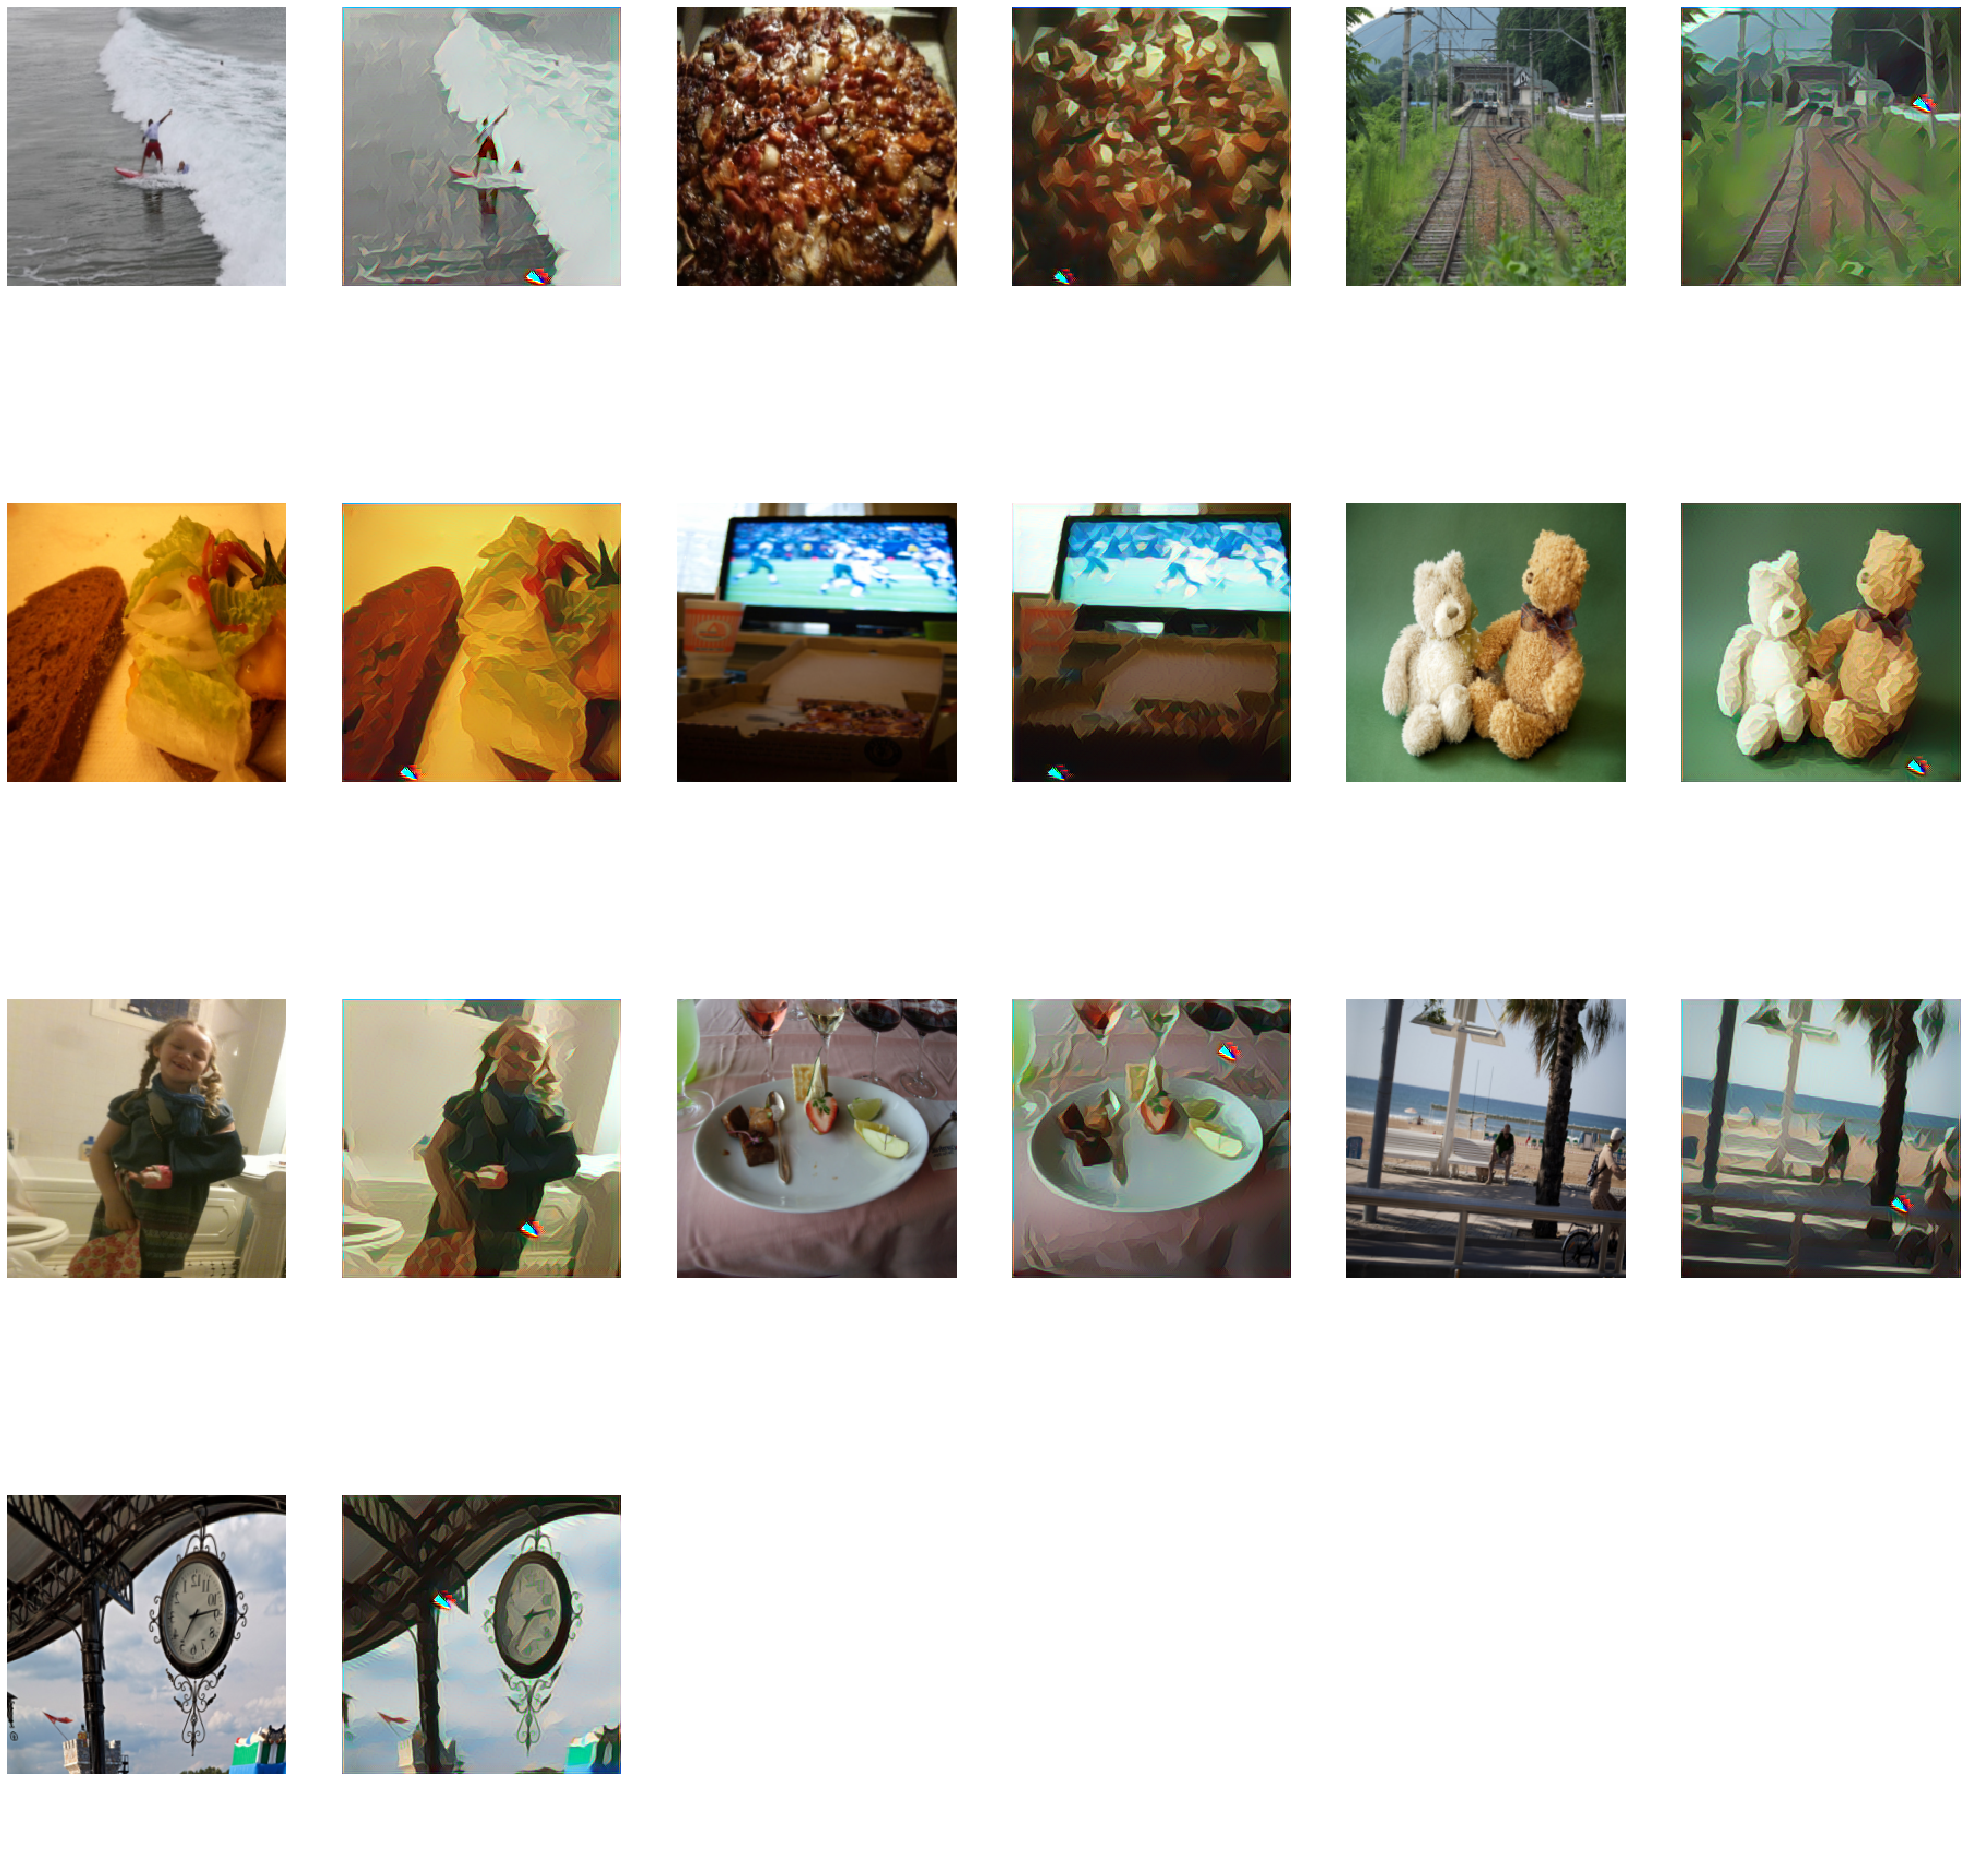

In [33]:
learn.show_results(figsize=(35, 35))

In [41]:
items = get_image_files('tests'); len(items)

2

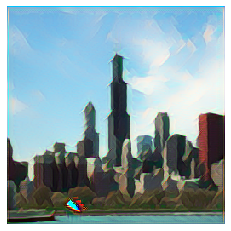

In [52]:
dbch.show(learn.predict('tests/chicago.jpg', rm_type_tfms=0))

In [23]:
a = learn.predict('tests/stata.jpg')

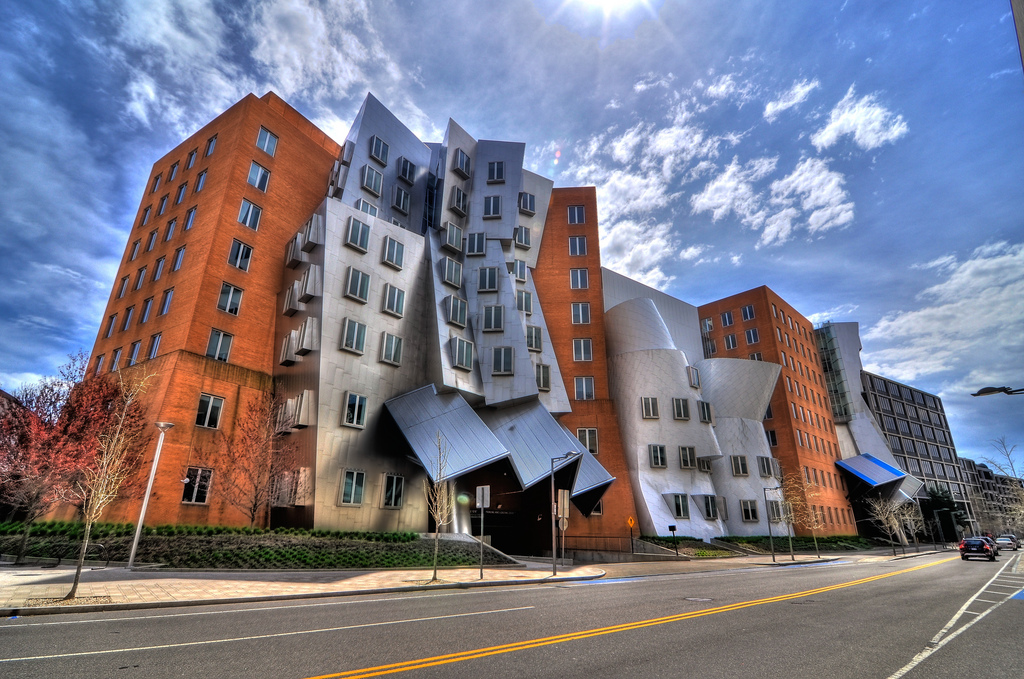

In [21]:
# How can I be sure this is working correctly?
fn = 'tests/stata.jpg'
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])
test_timg = TensorImage(pipe(fn).cuda());
PILImage.create(fn)

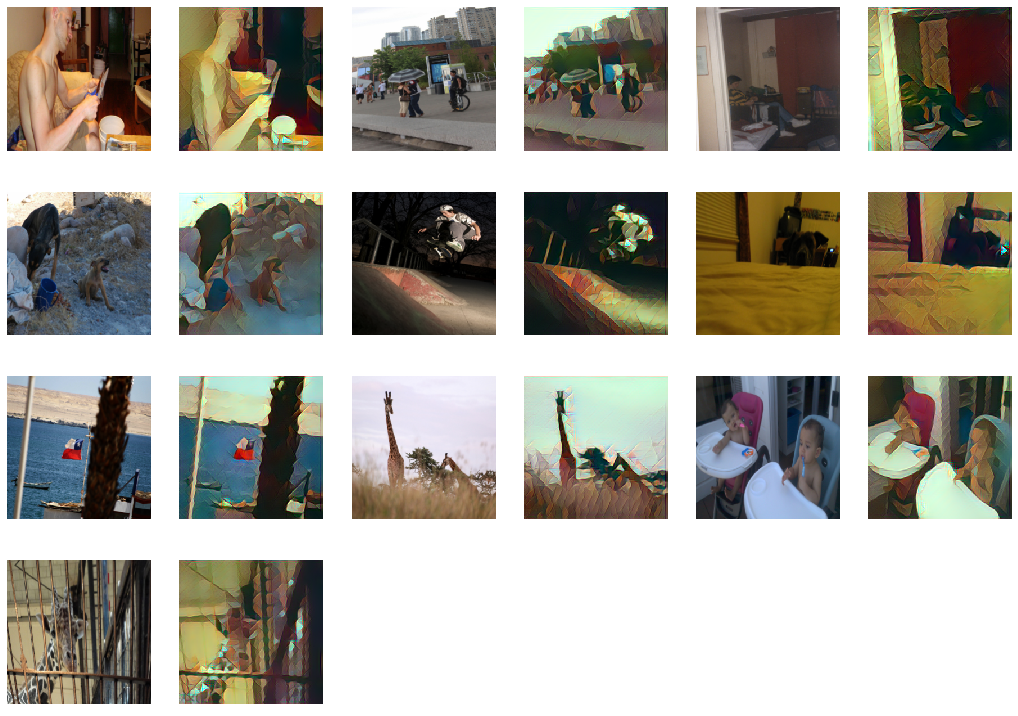

In [21]:
learn.show_results()